In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

import numpy.random as rnd
import tensorflow as tf
import time

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [3]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [4]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [6]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

# PCA with Auto Linear encoder

Build data set:

In [5]:
def prepare3DDataSet(seed=4):
  rnd.seed(seed)
  m = 200
  w1, w2 = 0.1, 0.3
  noise = 0.1

  angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
  data = np.empty((m, 3))
  data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
  data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
  data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)
  return data

In [6]:
rnd.rand(3)

array([0.25150547, 0.48921522, 0.89930311])

In [7]:
def standardizeSplitData(data,trainRatio=0.5):
  from sklearn.preprocessing import StandardScaler
  total,dimSample = np.shape(data)
  trainSize = np.int32(total * trainRatio)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(data[:trainSize])
  X_test = scaler.transform(data[trainSize:])
  return X_train, X_test

In [8]:
d=prepare3DDataSet()
X_train,X_test = standardizeSplitData(d,0.5)

In [9]:
reset_graph()

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01

with tf.name_scope("network"):
  X = tf.placeholder(tf.float32, shape=[None, n_inputs])
  hidden = tf.layers.dense(X, n_hidden)
  outputs = tf.layers.dense(hidden, n_outputs)

with tf.name_scope("loss"):
  reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate)
  training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [10]:
#show_graph(tf.get_default_graph())

In [11]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

the 3d data projected to 2d plane

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


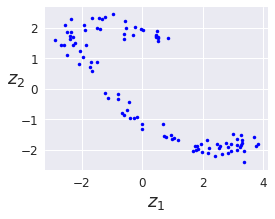

In [12]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)

plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


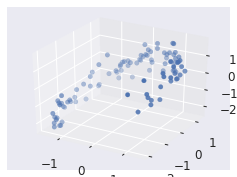

In [13]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2])
#ax.plot3D(X_train[:,0], X_train[:,1], X_train[:,2])


plt.show()

# Stacked Autoencoders

![title](img/Sandwich_autoencoder.png)

    Taking MNIST

In [13]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [15]:

reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001
#l2_reg = 0.01
#l2_reg=0.0000000000000001
with  tf.name_scope("input"):
  X = tf.placeholder(tf.float32, shape=[None, n_inputs])

with tf.name_scope("network"):
  he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
  #Equivalent to:
  #he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
  l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
  my_dense_layer = partial(tf.layers.dense,
                           activation=tf.nn.elu,
                           kernel_initializer=he_init,
                           kernel_regularizer=l2_regularizer)

  hidden1 = my_dense_layer(X, n_hidden1)
  hidden2 = my_dense_layer(hidden1, n_hidden2)
  hidden3 = my_dense_layer(hidden2, n_hidden3)
  outputs = my_dense_layer(hidden3, n_outputs, activation=None)

with tf.name_scope("loss"):
  reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
  reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
  loss = tf.add_n([reconstruction_loss] + reg_losses)
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate)
  training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

In [16]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./my_model_all_layers.ckpt")                  # not shown

0 Train MSE: 0.023205144
1 Train MSE: 0.011404502
2 Train MSE: 0.010232414
3 Train MSE: 0.009904518
4 Train MSE: 0.010378644


INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


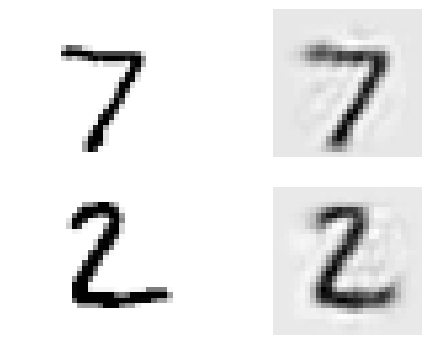

In [18]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")


# Typing weight

It is common to tie the weights of the encoder and the decoder (weights_decoder = tf.transpose(weights_encoder)). Unfortunately this makes it impossible (or very tricky) to use the tf.layers.dense() function, so we need to build the Autoencoder manually:

In [5]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [10]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

with tf.name_scope("input"):
  X = tf.placeholder(tf.float32, shape=[None, n_inputs])

with tf.name_scope("network"):
  weights1_init = initializer([n_inputs, n_hidden1])
  weights2_init = initializer([n_hidden1, n_hidden2])

  weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
  weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
  weights3 = tf.transpose(weights2, name="weights3")  # tied weights
  weights4 = tf.transpose(weights1, name="weights4")  # tied weights

  biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
  biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
  biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
  biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

  hidden1 = activation(tf.matmul(X, weights1) + biases1)
  hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
  hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
  outputs = tf.matmul(hidden3, weights4) + biases4

with tf.name_scope("loss"):
  reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
  reg_loss = regularizer(weights1) + regularizer(weights2)
  loss = reconstruction_loss + reg_loss

with tf.name_scope("training"):
  optimizer = tf.train.AdamOptimizer(learning_rate)
  training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [22]:
#show_graph(tf.get_default_graph())

In [15]:

n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.015195215
1 Train MSE: 0.015516772
2 Train MSE: 0.016547618
3 Train MSE: 0.016343689
4 Train MSE: 0.01704003
5 Train MSE: 0.017736377
6 Train MSE: 0.017486578
7 Train MSE: 0.018286372
8 Train MSE: 0.018025836
9 Train MSE: 0.01748106


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


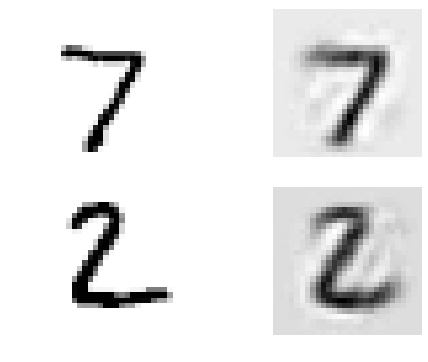

In [16]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

# Training one Autoencoder at a time in multiple graphs <br>
to speed up the training

There are many ways to train one Autoencoder at a time. The first approach it to train each Autoencoder using a different graph, then we create the Stacked Autoencoder by simply initializing it with the weights and biases copied from these Autoencoders.

Let's create a function that will train one autoencoder and return the transformed training set (i.e., the output of the hidden layer) and the model parameters.

![title](img/TrainAutoencoderMultipleGraphs.png)

In [5]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005
from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005,
                      activation=tf.nn.elu, seed=42):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            activation=activation,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=None, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

Now let's train two Autoencoders. The first one is trained on the training data, and the second is trained on the previous Autoencoder's hidden layer output:

In [8]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.01839816
1 Train MSE: 0.017738502
2 Train MSE: 0.0196133
3 Train MSE: 0.019356335
0 Train MSE: 0.004204875
1 Train MSE: 0.0045220857
2 Train MSE: 0.004538194
3 Train MSE: 0.004361495


Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoders we just trained:

In [9]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


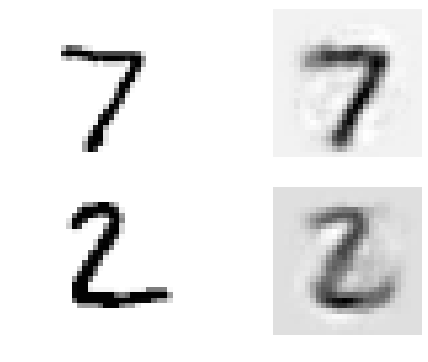

In [14]:
show_reconstructed_digits(X, outputs)

# Training one Autoencoder at a time in a single graph

Another approach is to use a single graph. To do this, we create the graph for the full Stacked Autoencoder, but then we also add operations to train each Autoencoder independently: phase 1 trains the bottom and top layer (ie. the first Autoencoder) and phase 2 trains the two middle layers (ie. the second Autoencoder).

![title](img/TrainAutoencoderSingleGraph.png)

In [11]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer() #HE initialization

with tf.name_scope("input"):
  X = tf.placeholder(tf.float32, shape=[None, n_inputs])

with tf.name_scope("initialize_weight_bias"):
  weights1_init = initializer([n_inputs, n_hidden1])
  weights2_init = initializer([n_hidden1, n_hidden2])
  weights3_init = initializer([n_hidden2, n_hidden3])
  weights4_init = initializer([n_hidden3, n_outputs])

  weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
  weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
  weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
  weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

  biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
  biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
  biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
  biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

with tf.name_scope("network"):
  hidden1 = activation(tf.matmul(X, weights1) + biases1)
  hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
  hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
  outputs = tf.matmul(hidden3, weights4) + biases4

with tf.name_scope("loss"):
  reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

with tf.name_scope("optimizer"):
  optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("training_phase1"):
  phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
  phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
  phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
  phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
  phase1_training_op = optimizer.minimize(phase1_loss)
  
with tf.name_scope("training_phase2"):
  phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
  phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
  phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
  train_vars = [weights2, biases2, weights3, biases3]
  phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [12]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [46]:
start=time.clock()
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    #init.run()
    sess.run(init)
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)
end=time.clock()

Training phase #1
0 Train MSE: 0.0078093885
1 Train MSE: 0.007379588
2 Train MSE: 0.0075359163
3 Train MSE: 0.007973703
Training phase #2
0 %Train MSE: 0.32633278
1 Train MSE: 0.006988588
2 Train MSE: 0.0034106479
39% Train MSE: 0.0023017523
Test MSE: 0.009743598


In [47]:

print("{0},{1},{2}".format(start,end,end-start))

360.682055,430.224664,69.54260900000003


# Cache the frozen layer outputs

Since hidden layer 1 is frozen during phase 2, its output will always be the same for any given training instance. To avoid having to recompute the output of hidden layer 1 at every single epoch, you can compute it for the whole training set at the end of phase 1, then directly feed the cached output of hidden layer 1 during phase 2. This can give you a nice performance boost.

In [13]:
start=time.clock()
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [10, 10]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)
end=time.clock()

Training phase #1
0 Train MSE: 0.007242767
1 Train MSE: 0.0073859976
2 Train MSE: 0.007734456
3 Train MSE: 0.007594901
4 Train MSE: 0.007968022
5 Train MSE: 0.008858566
6 Train MSE: 0.008036565
7 Train MSE: 0.008885448
8 Train MSE: 0.008804582
9 Train MSE: 0.071340844
Training phase #2
0 Train MSE: 5.6562032e-05
1 Train MSE: 4.5831337e-05
2 Train MSE: 4.9849787e-05
3 Train MSE: 4.159702e-05
4 Train MSE: 3.6294397e-05
5 Train MSE: 4.878827e-05
6 Train MSE: 4.6694262e-05
79% Train MSE: 3.5089648e-05
8 Train MSE: 4.8061895e-05
9 Train MSE: 5.711256e-05
Test MSE: 0.06902963


In [49]:
print("{0},{1},{2}".format(start,end,end-start))

430.292929,497.207766,66.91483699999998


INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


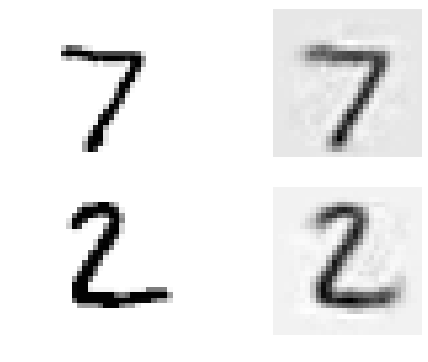

In [52]:
show_reconstructed_digits(X, outputs,"./my_model_one_at_a_time.ckpt")

#Visualizing the feature

Show the first 5 neurons of first layer

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt
(300, 784)
Totally we have 300 neurons, each neurons has dimension:784


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


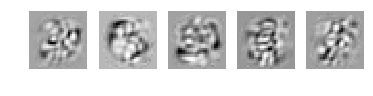

In [61]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt")
    weights1_val = weights1.eval()
    numNeuron,dim = np.shape(weights1_val.T)
    print("Totally we have {0} neurons, each neurons has dimension:{1}".format(numNeuron,dim))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])
plt.show()

# Unsupervised pretraining

Current Deep Learning tsunami is the discovery in 2006 by Geoffrey Hinton et al. that deep neural networks can be pretrained in an unsupervised fashion. They used restricted Boltzmann machines for that (see Appendix E), but in 2007 Yoshua Bengio et al. showed2 that autoencoders worked just as well.

Below is an classifier use case of unsupervised training 

In [15]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

with tf.name_scope("set_para"):
  activation = tf.nn.elu
  regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
  initializer = tf.contrib.layers.variance_scaling_initializer()

with tf.name_scope("input"):
  X = tf.placeholder(tf.float32, shape=[None, n_inputs])
  y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("initialize_weight_bias"):
  weights1_init = initializer([n_inputs, n_hidden1])
  weights2_init = initializer([n_hidden1, n_hidden2])
  weights3_init = initializer([n_hidden2, n_outputs])

  weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
  weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
  weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

  biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
  biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
  biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

with tf.name_scope("network"):
  hidden1 = activation(tf.matmul(X, weights1) + biases1)
  hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
  logits = tf.matmul(hidden2, weights3) + biases3

with tf.name_scope("loss"):
  cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
  loss = cross_entropy + reg_loss

with tf.name_scope("training"):
  optimizer = tf.train.AdamOptimizer(learning_rate)
  training_op = optimizer.minimize(loss)

with tf.name_scope("validate"):
  correct = tf.nn.in_top_k(logits, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))



In [16]:
init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

Using regulator training:

In [9]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.94666666 Test accuracy: 0.9243
1 Train accuracy: 0.97333336 Test accuracy: 0.9429
2 Train accuracy: 0.98 Test accuracy: 0.9405
3 Train accuracy: 0.98 Test accuracy: 0.9513


Now reusing the first two layers of the autoencoder we pretrained:

In [17]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.93333334	Test accuracy: 0.9104
1 Train accuracy: 0.94666666	Test accuracy: 0.937
2 Train accuracy: 0.98	Test accuracy: 0.9399
3 Train accuracy: 0.98	Test accuracy: 0.9544


# Stacked denoising Autoencoder

Using autoencoder

In [19]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [20]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [21]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [22]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.043670513
1 Train MSE: 0.04378741
2 Train MSE: 0.039921924
3 Train MSE: 0.042189576
4 Train MSE: 0.043090843
5 Train MSE: 0.04114331
6 Train MSE: 0.038128257
7 Train MSE: 0.040296283
8 Train MSE: 0.039769772
9 Train MSE: 0.039054755


Using dropout

In [23]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [24]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [26]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.031153888
1 Train MSE: 0.028971797
2 Train MSE: 0.029892428
3 Train MSE: 0.03035635
4 Train MSE: 0.027297778
5 Train MSE: 0.030242754
6 Train MSE: 0.028324733
7 Train MSE: 0.027807191
8 Train MSE: 0.027470574
9 Train MSE: 0.028721612


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


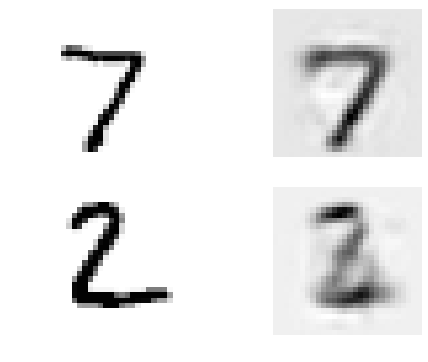

In [27]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

# Sparse Autoencoder
Reward the model to learn interesting feature by reducing activation neuron which are too closed to each other

[0, 1, 0, 0.95]

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


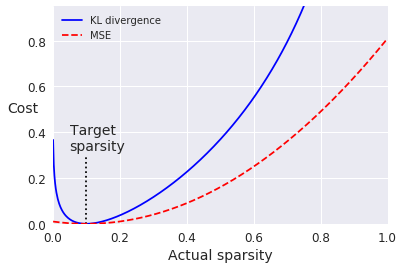

In [30]:
#KL has a stronger gradient of cost vs sparity as shown
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])


In [35]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

In [36]:
learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
outputs = tf.layers.dense(hidden1, n_outputs)                     # not shown

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [37]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.06578157 	Sparsity loss: 0.12064787 	Total loss: 0.08991115
1 Train MSE: 0.05366825 	Sparsity loss: 0.0028556949 	Total loss: 0.05423939
2 Train MSE: 0.047966443 	Sparsity loss: 0.017651414 	Total loss: 0.051496726
3 Train MSE: 0.043435935 	Sparsity loss: 0.013339343 	Total loss: 0.046103805
4 Train MSE: 0.038441632 	Sparsity loss: 0.0089600785 	Total loss: 0.04023365
5 Train MSE: 0.03483534 	Sparsity loss: 0.019739043 	Total loss: 0.038783148
6 Train MSE: 0.030506823 	Sparsity loss: 0.0095804855 	Total loss: 0.03242292
7 Train MSE: 0.027226448 	Sparsity loss: 0.054727707 	Total loss: 0.03817199
8 Train MSE: 0.025954578 	Sparsity loss: 0.061351806 	Total loss: 0.03822494
9 Train MSE: 0.022733627 	Sparsity loss: 0.02370768 	Total loss: 0.027475163
10 Train MSE: 0.021956444 	Sparsity loss: 0.023740413 	Total loss: 0.026704527
11 Train MSE: 0.021667888 	Sparsity loss: 0.043139562 	Total loss: 0.0302958
12 Train MSE: 0.019326458 	Sparsity loss: 0.058422886 	Total loss: 0.031